# Texas Inpatient Discharg - Model

### Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import streamlit as st
import numpy as np
import pandas as pd
import joblib

from scipy import stats
import yaml, time, sys, os, glob

import seaborn as sns
sns.set_style("darkgrid")

from IPython.display import display, Markdown
pd.set_option('display.max_columns', None)  

DATASET = "Texas_Inpatient_Discharge"
SPLIT_TRAINING = True
DEBUG = False
SEED = 42

COLAB = 'google.colab' in sys.modules
if COLAB:
    ROOT = f"/content/gdrive/MyDrive/datasets/{DATASET.replace(' ','_')}/"
else:
    ROOT = "./"

import my_lib

In [57]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.feature_selection import SelectPercentile, chi2, RFECV

#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier,StackingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV, cross_val_score

### Read In Data

In [58]:
df = pd.read_pickle(f"{ROOT}/data/df_train_preprocess_00_of_5.pkl")
print(df.shape)
df.head()

(199939, 43)


,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PAT_COUNTRY,PUBLIC_HEALTH_REGION,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,TARGET,PROVIDER_NAME_col_0,PROVIDER_NAME_col_1,PROVIDER_NAME_col_2,PROVIDER_NAME_col_3,PROVIDER_NAME_col_4,PROVIDER_NAME_col_5,PROVIDER_NAME_col_6,COUNTY_col_0,COUNTY_col_1,COUNTY_col_2,COUNTY_col_3,COUNTY_col_4,COUNTY_col_5,COUNTY_col_6,ADMITTING_DIAGNOSIS_col_0,ADMITTING_DIAGNOSIS_col_1,ADMITTING_DIAGNOSIS_col_2,ADMITTING_DIAGNOSIS_col_3,ADMITTING_DIAGNOSIS_col_4,ADMITTING_DIAGNOSIS_col_5,ADMITTING_DIAGNOSIS_col_6,PRINC_DIAG_CODE_col_0,PRINC_DIAG_CODE_col_1,PRINC_DIAG_CODE_col_2,PRINC_DIAG_CODE_col_3,PRINC_DIAG_CODE_col_4,PRINC_DIAG_CODE_col_5,PRINC_DIAG_CODE_col_6,POA_OTH_DIAG_CODE_COUNT,POA_E_CODE_COUNT
992358,1,1,TX,US,03,M,4,2,6,78650,78650,Y,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,8,0
900799,1,1,TX,US,11,F,4,1,4,7804,4359,Y,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,14,0
770151,1,1,TX,US,11,M,4,1,6,42731,42731,Y,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,11,0
762640,1,1,TX,US,07,F,2,1,6,78959,07070,Y,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,13,0
896831,4,5,TX,US,08,M,4,2,4,V3000,U,NaN,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


#### Read In grading csv

In [59]:
df_grading = pd.read_csv(f"{ROOT}/orig/grading.csv.gz", compression="gzip")

print(df_grading.shape)
df_grading.head()


/tmp/ipykernel_5711/3517273426.py:1: DtypeWarning: Columns (4,8,18,91,92,93,94,95,96,97,98,103,105,106,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df_grading = pd.read_csv(f"{ROOT}/orig/grading.csv.gz", compression="gzip")


(100000, 193)


,RECORD_ID,DISCHARGE,THCIC_ID,PROVIDER_NAME,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,SPEC_UNIT_1,SPEC_UNIT_2,SPEC_UNIT_3,SPEC_UNIT_4,SPEC_UNIT_5,PAT_STATE,PAT_ZIP,PAT_COUNTRY,COUNTY,PUBLIC_HEALTH_REGION,PAT_STATUS,SEX_CODE,RACE,ETHNICITY,ADMIT_WEEKDAY,PAT_AGE,FIRST_PAYMENT_SRC,SECONDARY_PAYMENT_SRC,TYPE_OF_BILL,TOTAL_CHARGES,TOTAL_NON_COV_CHARGES,TOTAL_CHARGES_ACCOMM,TOTAL_NON_COV_CHARGES_ACCOMM,TOTAL_CHARGES_ANCIL,TOTAL_NON_COV_CHARGES_ANCIL,POA_PROVIDER_INDICATOR,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,OTH_DIAG_CODE_1,POA_OTH_DIAG_CODE_1,OTH_DIAG_CODE_2,POA_OTH_DIAG_CODE_2,OTH_DIAG_CODE_3,POA_OTH_DIAG_CODE_3,OTH_DIAG_CODE_4,POA_OTH_DIAG_CODE_4,OTH_DIAG_CODE_5,POA_OTH_DIAG_CODE_5,OTH_DIAG_CODE_6,POA_OTH_DIAG_CODE_6,OTH_DIAG_CODE_7,POA_OTH_DIAG_CODE_7,OTH_DIAG_CODE_8,POA_OTH_DIAG_CODE_8,OTH_DIAG_CODE_9,POA_OTH_DIAG_CODE_9,OTH_DIAG_CODE_10,POA_OTH_DIAG_CODE_10,OTH_DIAG_CODE_11,POA_OTH_DIAG_CODE_11,OTH_DIAG_CODE_12,POA_OTH_DIAG_CODE_12,OTH_DIAG_CODE_13,POA_OTH_DIAG_CODE_13,OTH_DIAG_CODE_14,POA_OTH_DIAG_CODE_14,OTH_DIAG_CODE_15,POA_OTH_DIAG_CODE_15,OTH_DIAG_CODE_16,POA_OTH_DIAG_CODE_16,OTH_DIAG_CODE_17,POA_OTH_DIAG_CODE_17,OTH_DIAG_CODE_18,POA_OTH_DIAG_CODE_18,OTH_DIAG_CODE_19,POA_OTH_DIAG_CODE_19,OTH_DIAG_CODE_20,POA_OTH_DIAG_CODE_20,OTH_DIAG_CODE_21,POA_OTH_DIAG_CODE_21,OTH_DIAG_CODE_22,POA_OTH_DIAG_CODE_22,OTH_DIAG_CODE_23,POA_OTH_DIAG_CODE_23,OTH_DIAG_CODE_24,POA_OTH_DIAG_CODE_24,E_CODE_1,POA_E_CODE_1,E_CODE_2,POA_E_CODE_2,E_CODE_3,POA_E_CODE_3,E_CODE_4,POA_E_CODE_4,E_CODE_5,POA_E_CODE_5,E_CODE_6,POA_E_CODE_6,E_CODE_7,POA_E_CODE_7,E_CODE_8,POA_E_CODE_8,E_CODE_9,POA_E_CODE_9,E_CODE_10,POA_E_CODE_10,PRINC_SURG_PROC_CODE,PRINC_SURG_PROC_DAY,PRINC_ICD9_CODE,OTH_SURG_PROC_CODE_1,OTH_SURG_PROC_DAY_1,OTH_ICD9_CODE_1,OTH_SURG_PROC_CODE_2,OTH_SURG_PROC_DAY_2,OTH_ICD9_CODE_2,OTH_SURG_PROC_CODE_3,OTH_SURG_PROC_DAY_3,OTH_ICD9_CODE_3,OTH_SURG_PROC_CODE_4,OTH_SURG_PROC_DAY_4,OTH_ICD9_CODE_4,OTH_SURG_PROC_CODE_5,OTH_SURG_PROC_DAY_5,OTH_ICD9_CODE_5,OTH_SURG_PROC_CODE_6,OTH_SURG_PROC_DAY_6,OTH_ICD9_CODE_6,OTH_SURG_PROC_CODE_7,OTH_SURG_PROC_DAY_7,OTH_ICD9_CODE_7,OTH_SURG_PROC_CODE_8,OTH_SURG_PROC_DAY_8,OTH_ICD9_CODE_8,OTH_SURG_PROC_CODE_9,OTH_SURG_PROC_DAY_9,OTH_ICD9_CODE_9,OTH_SURG_PROC_CODE_10,OTH_SURG_PROC_DAY_10,OTH_ICD9_CODE_10,OTH_SURG_PROC_CODE_11,OTH_SURG_PROC_DAY_11,OTH_ICD9_CODE_11,OTH_SURG_PROC_CODE_12,OTH_SURG_PROC_DAY_12,OTH_ICD9_CODE_12,OTH_SURG_PROC_CODE_13,OTH_SURG_PROC_DAY_13,OTH_ICD9_CODE_13,OTH_SURG_PROC_CODE_14,OTH_SURG_PROC_DAY_14,OTH_ICD9_CODE_14,OTH_SURG_PROC_CODE_15,OTH_SURG_PROC_DAY_15,OTH_ICD9_CODE_15,OTH_SURG_PROC_CODE_16,OTH_SURG_PROC_DAY_16,OTH_ICD9_CODE_16,OTH_SURG_PROC_CODE_17,OTH_SURG_PROC_DAY_17,OTH_ICD9_CODE_17,OTH_SURG_PROC_CODE_18,OTH_SURG_PROC_DAY_18,OTH_ICD9_CODE_18,OTH_SURG_PROC_CODE_19,OTH_SURG_PROC_DAY_19,OTH_ICD9_CODE_19,OTH_SURG_PROC_CODE_20,OTH_SURG_PROC_DAY_20,OTH_ICD9_CODE_20,OTH_SURG_PROC_CODE_21,OTH_SURG_PROC_DAY_21,OTH_ICD9_CODE_21,OTH_SURG_PROC_CODE_22,OTH_SURG_PROC_DAY_22,OTH_ICD9_CODE_22,OTH_SURG_PROC_CODE_23,OTH_SURG_PROC_DAY_23,OTH_ICD9_CODE_23,OTH_SURG_PROC_CODE_24,OTH_SURG_PROC_DAY_24,OTH_ICD9_CODE_24,MS_MDC,MS_DRG,MS_GROUPER_VERSION_NBR,MS_GROUPER_ERROR_CODE,APR_MDC,APR_DRG,RISK_MORTALITY,ILLNESS_SEVERITY,APR_GROUPER_VERSION_NBR,APR_GROUPER_ERROR_CODE,ATTENDING_PHYSICIAN_UNIF_ID,OPERATING_PHYSICIAN_UNIF_ID,ENCOUNTER_INDICATOR,CERT_STATUS,FILLER_SPACE
0,420132203333,2013Q4,145000,University Medical Center,2,1,NaN,NaN,NaN,NaN,NaN,TX,79415,US,303.0,1.0,01,F,4.0,1,4,8,MC,ZZ,111,16352.05,0.0,5555.0,0.0,10797.05,0.0,M,V220,65981,Y,65911,N,64891,Y,66101,N,7923,N,V270,NaN,V0251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,734.0,1.0,734.0,741.0,1.0,741.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199939 entries, 992358 to 410879
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   TYPE_OF_ADMISSION          199939 non-null  category
 1   SOURCE_OF_ADMISSION        199939 non-null  category
 2   PAT_STATE                  199939 non-null  category
 3   PAT_COUNTRY                199939 non-null  category
 4   PUBLIC_HEALTH_REGION       199939 non-null  category
 5   SEX_CODE                   199939 non-null  category
 6   RACE                       199939 non-null  category
 7   ETHNICITY                  199939 non-null  category
 8   ADMIT_WEEKDAY              199939 non-null  category
 9   ADMITTING_DIAGNOSIS        199674 non-null  object  
 10  PRINC_DIAG_CODE            199939 non-null  object  
 11  POA_PRINC_DIAG_CODE        156951 non-null  object  
 12  TARGET                     199939 non-null  category
 13  PROVIDER_

### Specifying Feature and Target Values

In [61]:
target="TARGET"

#cat_features = [catFeature for catFeature in df.select_dtypes("category").columns if catFeature not in target]

#print(cat_features)

cat_features=[
    "TYPE_OF_ADMISSION",
    "SOURCE_OF_ADMISSION",
    "PAT_STATE",
    "PUBLIC_HEALTH_REGION",
    "ADMITTING_DIAGNOSIS",
    "PRINC_DIAG_CODE",
    "POA_PRINC_DIAG_CODE",
    "ADMIT_WEEKDAY",
    #"SEX_CODE",
    #"RACE"
]

#num_features=[numFeature for numFeature in df.select_dtypes("int").columns if numFeature not in target]

num_features=[]

features= cat_features + num_features




features


['TYPE_OF_ADMISSION',
 'SOURCE_OF_ADMISSION',
 'PAT_STATE',
 'PUBLIC_HEALTH_REGION',
 'ADMITTING_DIAGNOSIS',
 'PRINC_DIAG_CODE',
 'POA_PRINC_DIAG_CODE',
 'ADMIT_WEEKDAY']

### Creating Categorical and Numerical Transformers for Preprocessing

In [62]:
cat_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore')),
    ('selector', SelectPercentile(chi2,percentile=80)),
])

num_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
])

preprocessor = ColumnTransformer(transformers=[
    ('cat',cat_transformer,cat_features),
    ('num',num_transformer,num_features),
])

### Specifying Models for Model Selection

In [63]:
models = {
    #"LR": LogisticRegression(max_iter=1000),
    #"DT": DecisionTreeClassifier(),
    #"KNN": KNeighborsClassifier(),
    #"RF": RandomForestClassifier(),
    #"ET": ExtraTreesClassifier(),
    "XGB": XGBClassifier()
    #"LGBM": LGBMClassifier(),
    #"CB": CatBoostClassifier(silent=True),
    #"ADA": AdaBoostClassifier(n_estimators=100,random_state=SEED),
    #"GBRT": GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42) 
}

### Train Test Split

In [64]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.4, random_state=SEED)
X_train.shape, X_test.shape

((119963, 8), (79976, 8))

### Model Selection

In [65]:
for name,model in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
    print(name, "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

XGB Accuracy: 0.57 (+/- 0.01)


- LR Accuracy: 0.49 (+/- 0.01)
- DT Accuracy: 0.48 (+/- 0.00)
- KNN Accuracy: 0.43 (+/- 0.01)
- RF Accuracy: 0.48 (+/- 0.00)
- ET Accuracy: 0.48 (+/- 0.00)
- XGB Accuracy: 0.50 (+/- 0.01)
- LGBM Accuracy: 0.50 (+/- 0.00)
- CB Accuracy: 0.50 (+/- 0.00)
- ADA Accuracy: 0.49 (+/- 0.01)
- GBRT Accuracy: 0.49 (+/- 0.01)

##### As we can see from the models above XGB, LGBM and CB give use the best results we will use XGB moving forward

In [66]:
#preprocessor.fit(X_train,y_train)
#preprocessor.transform(X_train)
#preprocessor.transform(X_test)

X_train

,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,PAT_STATE,PUBLIC_HEALTH_REGION,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,POA_PRINC_DIAG_CODE,ADMIT_WEEKDAY
632486,3,2,TX,03,99649,99649,Y,5
353811,3,2,TX,05,4439,44020,Y,4
188575,1,1,TX,01,41071,41071,Y,3
151440,3,4,TX,06,V5789,U,NaN,2
732852,1,1,TX,06,5362,5363,Y,4
...,...,...,...,...,...,...,...,...
488104,4,5,TX,03,V3001,U,NaN,1
874523,1,1,TX,04,486,486,Y,5
715832,1,1,TX,06,28262,28242,Y,4
783859,2,1,TX,09,650,64421,Y,7


### Basic Model

In [67]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGB', XGBClassifier()),
])

In [68]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=80,
                                                                                    score_func=<function chi2 at 0x7feec4ca00d0>))]),
                                                  ['TYPE_OF_ADMISSION',
                                                   'SOURCE_OF_ADMISSION',
                                                   'PAT_STATE',
                                                   'PUBLIC_HEALTH_R...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [69]:
y_pred = model.predict(X_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.34      0.46     24526
           1       0.50      0.73      0.60     45874
           2       0.70      0.59      0.64     49563

    accuracy                           0.59    119963
   macro avg       0.64      0.55      0.56    119963
weighted avg       0.63      0.59      0.59    119963



##### Basic model with preprocessing gives us a score of 60% we will attempt to use different methods to increases this score

### Grid Search

In [70]:
param_grid = {
    'XGB__learning_rate': [0.01, 0.1, 0.5],
    'XGB__max_depth': [3, 5, 7],
    'XGB__n_estimators': [100, 500, 1000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

#grid_search.fit(X_train, y_train)

#print("Best parameters:", grid_search.best_params_)
#print("Best score:", grid_search.best_score_)

Best parameters: {'XGB__learning_rate': 0.5, 'XGB__max_depth': 3, 'XGB__n_estimators': 500}
Best score: 0.5722681188815673

##### Using grid search we were able to find the best parameters for the XGB classifier and will use it in a new model to see if it has improved our score

### 2nd Model - Using Opimised Parameters from Gridsearch

In [71]:
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('XGB', XGBClassifier(learning_rate=0.5, max_depth=3, n_estimators=500)),
])

model2.fit(X_train,y_train)

y_pred = model2.predict(X_train)

print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.41      0.51     24526
           1       0.53      0.68      0.60     45874
           2       0.70      0.65      0.67     49563

    accuracy                           0.61    119963
   macro avg       0.63      0.58      0.59    119963
weighted avg       0.63      0.61      0.61    119963



##### optimising the parameters for XGB has increased our best score by 2% we will use these new parameters moving forward and attempt to improve it further

### Checking Target Value Distribution

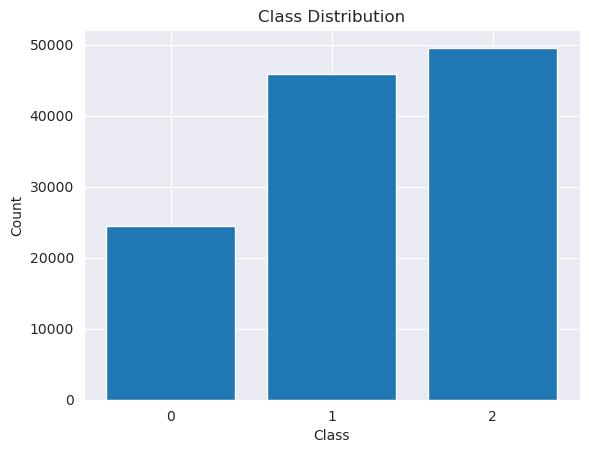

In [72]:
class_counts = pd.Series(y_train).value_counts()

# Create a bar chart to visualize the class distribution
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(class_counts.index)
plt.show()

##### From the graph above we can see that the 0 value has a lower count compared to 2 and 3 which are reasonabily close. We will balance this data out using SMOTE

### 3rd Model - Balancing Data Using Smote

In [73]:
model3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote',SMOTE(random_state=SEED)),
    ('Classifier', XGBClassifier(learning_rate=0.5, max_depth=3, n_estimators=500))
])

# model3.fit(X_train,y_train)

# y_pred = model3.predict(X_train)

# print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.48      0.53     24526
           1       0.53      0.66      0.59     45874
           2       0.71      0.61      0.66     49563

    accuracy                           0.60    119963
   macro avg       0.61      0.58      0.59    119963
weighted avg       0.61      0.60      0.60    119963

##### Our accuracy score has decrease by 1% while using smote, we will leave smote out from our pipelines moving forward.

### 4th Model - Using Stacked Learner

In [74]:
level_0_models = {
    "XGB": XGBClassifier(learning_rate=0.5, max_depth=3, n_estimators=500),
    "LGBM": LGBMClassifier(),
    "CB": CatBoostClassifier(silent=True),
}

level_1_model = XGBClassifier(learning_rate=0.5, max_depth=3, n_estimators=500)

In [75]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

model4 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('stacking',StackingClassifier( estimators=list(level_0_models.items()), final_estimator=level_1_model, 
    passthrough=True, cv=cv, stack_method="predict_proba"))
])

model4.fit(X_train,y_train)

y_pred = model4.predict(X_train)

print(classification_report(y_train,y_pred))


              precision    recall  f1-score   support

           0       0.67      0.45      0.54     24526
           1       0.54      0.67      0.60     45874
           2       0.70      0.66      0.68     49563

    accuracy                           0.62    119963
   macro avg       0.64      0.59      0.61    119963
weighted avg       0.63      0.62      0.62    119963



              precision    recall  f1-score   support

           0       0.67      0.45      0.54     24526
           1       0.54      0.67      0.60     45874
           2       0.70      0.66      0.68     49563

    accuracy                           0.62    119963
   macro avg       0.64      0.59      0.61    119963
weighted avg       0.63      0.62      0.62    119963

##### Using the top 3 models from model selection as our level 0 models in combination with our XGB classifier with optimised parameters has further improved our score by 1%

### Saving Model for Dashboard

In [76]:
joblib.dump(model4,"model.sav")

['model.sav']

### Generating Predictions 

In [77]:
predictions = model4.predict(df_grading)

df_grading_pred = pd.DataFrame({'TARGET': predictions}, index=df_grading.index)

#df_grading_pred = pd.DataFrame({'TARGET': predictions}, index=df_grading['RECORD_ID'])

df_grading_pred.to_csv('df_grading_pred.csv', index=False)

### Creating Archive with files

In [78]:
my_lib.make_assignment()

Creating archive: my_assignment.zip
	df_grading_pred.csv - OK
	01-Import.ipynb - OK
	02-EDA.ipynb - OK
	dashboard.py - OK
	my_lib.py - OK
	03-Model.ipynb - OK


### Conclusion

We managed to improve our base model from 50% to 62%. This was done by:

- Adding the features below improved our model by +9% : 
    - "ADMITTING_DIAGNOSIS"
    - "PRINC_DIAG_CODE"
    - "POA_PRINC_DIAG_CODE"
    - "ADMIT_WEEKDAY"


- Utilizing GridSearch to find the best parameters for the XGB classifier, resulting in an additional 2% improvement.

- Implementing a Stacked Learner approach by combining the predictions of the top 3 classifiers, which further improved the accuracy by 1%.

Overall, these enhancements helped us achieve a significant boost in the model's performance, increasing the accuracy from 50% to 62%.

Using SMOTE decreased our score by -1%

When the two features below were added our base model reached 60% compared to the 59% without these features,however the scores in the end were the same as the stacked learner didnt improve the score at all in this case. I chose to use less features and maintain the same score by using stacked learners.

- "SEX_CODE"
- "RACE"
